In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sagemaker.image_uris import retrieve
from sagemaker.predictor import Predictor
from sagemaker import image_uris
import boto3
import io
import os
import sagemaker

Matplotlib is building the font cache; this may take a moment.


In [3]:
nelson = pd.read_csv('datasets/regional/Nelson.csv',index_col=False)

In [4]:
nelson.index = nelson.date
nelson.index = pd.to_datetime(nelson.index)
nelson = nelson[['Nelson', 'lagged']]
nelson.head(5)

,Nelson,lagged
date,,
1992-01-31,115000.0,NaN
1992-02-29,108000.0,115000.0
1992-03-31,115000.0,108000.0
1992-04-30,116000.0,115000.0
1992-05-31,115000.0,116000.0


---

## AWS

### Using DeepAR

The data will be converted first to quarterly data as DeepAR uses multiple data points per timestep i.e, if using weekly timesteps, daily data per timestep is required. In this case we will use three months of data (3 values) per timestep (quarter).

In [70]:
def months_to_quarters(df):
    
    df = df[:-2][['Nelson']]
    df.rename(columns={'Nelson':'First_Month'}, inplace=True)
    df['Second_Month'] = None
    df['Third_Month'] = None
    for i in range(2, len(df), 3):
        s_month = df.loc[df.index[i-1],"First_Month"]
        f_month = df.loc[df.index[i-2],"First_Month"]
        df.loc[df.index[i], "Third_Month"] = df.loc[df.index[i], "First_Month"]
        df.loc[df.index[i], "Second_Month"] = s_month
        df.loc[df.index[i], "First_Month"] = f_month
    return df.dropna()

In [71]:
nelson_qrtly = months_to_quarters(nelson.copy())

In [72]:
nelson_qrtly

,First_Month,Second_Month,Third_Month
date,,,
1992-03-31,115000.0,108000.0,115000.0
1992-06-30,116000.0,115000.0,107000.0
1992-09-30,118000.0,116000.0,120000.0
1992-12-31,115000.0,122500.0,124000.0
1993-03-31,120000.0,125000.0,126000.0
...,...,...,...
2023-06-30,720000.0,770000.0,650000.0
2023-09-30,710000.0,695000.0,680000.0
2023-12-31,670500.0,650000.0,710000.0


In [74]:
train, test_and_validate = train_test_split(nelson_qrtly, 
                                            test_size=0.2, 
                                            random_state=42)

train_test, validate = train_test_split(test_and_validate, 
                                  test_size=0.5, 
                                  random_state=42)

In [75]:
bucket='c125236a3097401l7344380t1w4575200910-sandboxbucket-6het1vfa8iyd'
prefix='assignment3'
train_file='train.json'
test_file='test.json'
validate_file='validate.json'
whole_file='whole.json'
s3_resource = boto3.Session().resource('s3')

In [81]:
import json
import io

def upload_s3_json(filename, folder, dataframe):
    dates = [date.isoformat() for date in dataframe.index]
    data = ''
    for i in range(len(dataframe)):
        temp = {}
        temp["start"] = dates[i]
        temp["target"] = [val for val in dataframe.iloc[i].values]
        data += f'{json.dumps(temp)}\n'
    bytes_data = io.BytesIO(data.encode("utf-8"))
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body= bytes_data)

upload_s3_json(train_file, 'train', train)
upload_s3_json(test_file, 'test', train_test)
upload_s3_json(validate_file, 'validate', validate)

In [85]:
role=sagemaker.get_execution_role()
s3_output_location="s3://{}/{}/output/".format(bucket,prefix)
container = image_uris.retrieve(framework='forecasting-deepar', region=boto3.Session().region_name)

In [86]:
container

'522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:1'

In [91]:
hyperparams={
    "time_freq":"3M",
    "context_length":"1",
    "prediction_length":"2",
    "epochs":"100"}

In [92]:
deep_ar=sagemaker.estimator.Estimator(container,
                                        role,
                                        instance_count=1,
                                        instance_type='ml.m5.xlarge',
                                        output_path=s3_output_location,
                                        hyperparameters=hyperparams,
                                        sagemaker_session=sagemaker.Session())

In [93]:
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='json')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='json')

data_channels = {'train': train_channel, 'test': validate_channel}

In [95]:
deep_ar.fit(inputs=data_channels, logs=False)

INFO:sagemaker:Creating training-job with name: forecasting-deepar-2024-10-09-23-43-43-157



2024-10-09 23:43:45 Starting - Starting the training job..
2024-10-09 23:44:02 Starting - Preparing the instances for training....
2024-10-09 23:44:28 Downloading - Downloading input data.....
2024-10-09 23:44:54 Downloading - Downloading the training image.............
2024-10-09 23:46:05 Training - Training image download completed. Training in progress............
2024-10-09 23:47:05 Uploading - Uploading generated training model
2024-10-09 23:47:13 Completed - Training job completed


In [97]:
nelson_qrtly[-1:]

,First_Month,Second_Month,Third_Month
date,,,
2024-06-30,705000.0,670000.0,648000.0


In [98]:
sagemaker_session = sagemaker.Session()
predictor = Predictor(endpoint_name='deep-ar-100', sagemaker_session=sagemaker_session)

In [100]:
data = {
    "instances": [
        {
            "start": "2024-06-30 00:00:00",
            "target": [705000.0, 670000.0, 648000.0],
        }
    ],
    "configuration": {
        "num_samples": 100,
        "output_types": ["mean", "quantiles"],
        "quantiles": ["0.1", "0.5", "0.9"]
    }
}

payload = json.dumps(data)
response = predictor.predict(payload, initial_args={"ContentType": "application/json"})

In [102]:
result = json.loads(response.decode('utf-8'))

In [107]:
result

{'predictions': [{'mean': [617007.875, 600444.5],
   'quantiles': {'0.1': [556193.75, 543589.6875],
    '0.5': [621433.5, 596463.375],
    '0.9': [675815.125, 662208.0]}}]}

In [152]:
means = [float(val) for val in result['predictions'][0]['mean']]
q_01 = [float(val) for val in result['predictions'][0]['quantiles']['0.1']]
q_05 = [float(val) for val in result['predictions'][0]['quantiles']['0.5']]
q_09 = [float(val) for val in result['predictions'][0]['quantiles']['0.9']]
index = [1,2]

Text(0.5, 0, 'Prediction')

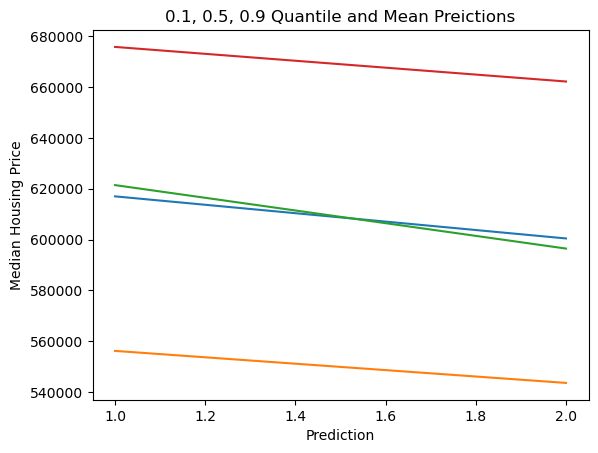

In [154]:
plt.plot(index, means)
plt.plot(index, q_01)
plt.plot(index, q_05)
plt.plot(index, q_09)
plt.title("0.1, 0.5, 0.9 Quantile and Mean Preictions")
plt.ylabel("Median Housing Price")
plt.xlabel("Prediction")

In [133]:
index = [val for val in nelson_qrtly.index]
index.append(index[-1] + (pd.tseries.offsets.MonthEnd() * 3))
index.append(index[-1] + (pd.tseries.offsets.MonthEnd() * 3))

Text(0.5, 1.0, 'Forecast Horizon for Median House price in NZ')

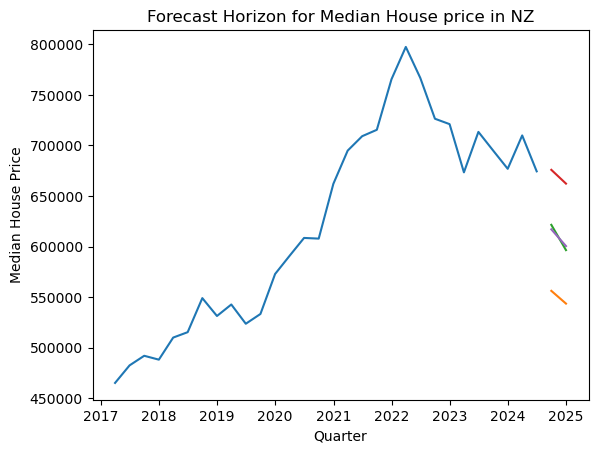

In [148]:
plt.plot(index[100:-2], nelson_qrtly[100:].apply(np.mean, axis=1))
plt.plot(index[-2:], q_01)
plt.plot(index[-2:], q_05)
plt.plot(index[-2:], q_09)
plt.plot(index[-2:], means)
plt.xlabel("Quarter")
plt.ylabel("Median House Price")
plt.title("Forecast Horizon for Median House price in NZ")

---

The data will now be converted to 2-Monthly intervals

In [159]:
def months_to_2months(df):
    
    df = df[['Nelson']]
    df.rename(columns={'Nelson':'First_Month'}, inplace=True)
    df['Second_Month'] = None
    for i in range(1, len(df), 2):
        f_month = df.loc[df.index[i-1],"First_Month"]
        df.loc[df.index[i], "Second_Month"] = df.loc[df.index[i], "First_Month"]
        df.loc[df.index[i], "First_Month"] = f_month
    return df.dropna()

In [163]:
nelson_bimonthly = months_to_2months(nelson.copy())

In [164]:
nelson_bimonthly.head(5)

,First_Month,Second_Month
date,,
1992-02-29,115000.0,108000.0
1992-04-30,115000.0,116000.0
1992-06-30,115000.0,107000.0
1992-08-31,118000.0,116000.0
1992-10-31,120000.0,115000.0


In [165]:
train, test = train_test_split(nelson_bimonthly, 
                                            test_size=0.2, 
                                            random_state=42)

In [166]:
bucket='c125236a3097401l7344380t1w4575200910-sandboxbucket-6het1vfa8iyd'
prefix='assignment3'
train_file='train_bi.json'
test_file='test_bi.json'
whole_file='whole_bi.json'
s3_resource = boto3.Session().resource('s3')

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [167]:
upload_s3_json(train_file, 'train', train)
upload_s3_json(test_file, 'test', test)

In [168]:
role=sagemaker.get_execution_role()
s3_output_location="s3://{}/{}/output/".format(bucket,prefix)
container = image_uris.retrieve(framework='forecasting-deepar', region=boto3.Session().region_name)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [169]:
container

'522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:1'

In [174]:
hyperparams={
    "time_freq":"2M",
    "context_length":"1",
    "prediction_length":"1",
    "epochs":"100"}

In [175]:
deep_ar=sagemaker.estimator.Estimator(container,
                                        role,
                                        instance_count=1,
                                        instance_type='ml.m5.xlarge',
                                        output_path=s3_output_location,
                                        hyperparameters=hyperparams,
                                        sagemaker_session=sagemaker.Session())

In [176]:
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='json')

test_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,test_file),
    content_type='json')

data_channels = {'train': train_channel, 'test': test_channel}

In [177]:
deep_ar.fit(inputs=data_channels, logs=False)

INFO:sagemaker:Creating training-job with name: forecasting-deepar-2024-10-10-00-37-27-039



2024-10-10 00:37:28 Starting - Starting the training job..
2024-10-10 00:37:44 Starting - Preparing the instances for training....
2024-10-10 00:38:11 Downloading - Downloading input data.....
2024-10-10 00:38:41 Downloading - Downloading the training image............
2024-10-10 00:39:47 Training - Training image download completed. Training in progress..........
2024-10-10 00:40:37 Uploading - Uploading generated training model..
2024-10-10 00:40:50 Completed - Training job completed


In [179]:
nelson_bimonthly.tail(5)

,First_Month,Second_Month
date,,
2023-12-31,650000.0,710000.0
2024-02-29,675000.0,732500.0
2024-04-30,722000.0,705000.0
2024-06-30,670000.0,648000.0
2024-08-31,657000.0,693000.0


In [180]:
sagemaker_session = sagemaker.Session()
predictor = Predictor(endpoint_name='deep-ar-100-bi', sagemaker_session=sagemaker_session)

In [181]:
data = {
    "instances": [
        {
            "start": "2024-08-31 00:00:00",
            "target": [657000.0, 693000.0],
        }
    ],
    "configuration": {
        "num_samples": 100,
        "output_types": ["mean", "quantiles"],
        "quantiles": ["0.1", "0.5", "0.9"]
    }
}

payload = json.dumps(data)
response = predictor.predict(payload, initial_args={"ContentType": "application/json"})

In [182]:
result = json.loads(response.decode('utf-8'))

In [198]:
means = []
means.append(nelson_bimonthly[-1:].apply(np.mean, axis=1).values[0])
temp = [float(val) for val in result['predictions'][0]['mean']]
means.append(temp[0])

In [201]:
index = [val for val in nelson_bimonthly.index]
index.append(index[-1] + (pd.tseries.offsets.MonthEnd() * 2))

Text(0.5, 1.0, 'Forecast Horizon for Median House price in NZ')

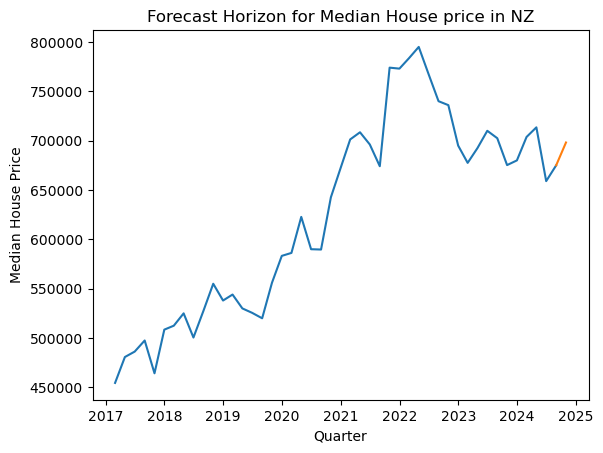

In [204]:
plt.plot(index[150:-1], nelson_bimonthly[150:].apply(np.mean, axis=1))
plt.plot(index[-2:], means)
plt.xlabel("Quarter")
plt.ylabel("Median House Price")
plt.title("Forecast Horizon for Median House price in NZ")

### Metrics

In [221]:
def get_predictions(df):
    predictions = []
    for i in range(len(df)-1):
        data = {
            "instances": [
                {
                    "start": df.index[i].isoformat(),
                    "target": [val for val in df.iloc[i]],
                }
            ],
            "configuration": {
                "num_samples": 100,
                "output_types": ["mean", "quantiles"],
                "quantiles": ["0.1", "0.5", "0.9"]
            }
        }

        payload = json.dumps(data)
        response = predictor.predict(payload, initial_args={"ContentType": "application/json"})
        result = json.loads(response.decode('utf-8'))
        pred = [float(val) for val in result['predictions'][0]['mean']]
        
        predictions.append(pred[0])
        
    return predictions

In [222]:
predictions = get_predictions(nelson_bimonthly.copy())

In [230]:
predictions = pd.DataFrame(predictions, index=nelson_bimonthly.index[1:], columns=["predictions"])

In [234]:
actual = nelson_bimonthly[1:].apply(np.mean, axis=1)

In [237]:
mse = mean_squared_error(predictions.predictions, actual.values)
rmse = root_mean_squared_error(predictions.predictions, actual.values)
mae = mean_absolute_error(predictions.predictions, actual.values)
mdae = median_absolute_error(predictions.predictions, actual.values)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MDAE: {mdae}')

MSE: 546125232.9963598
RMSE: 23369.322476194295
MAE: 17212.46045673076
MDAE: 12926.687500000116


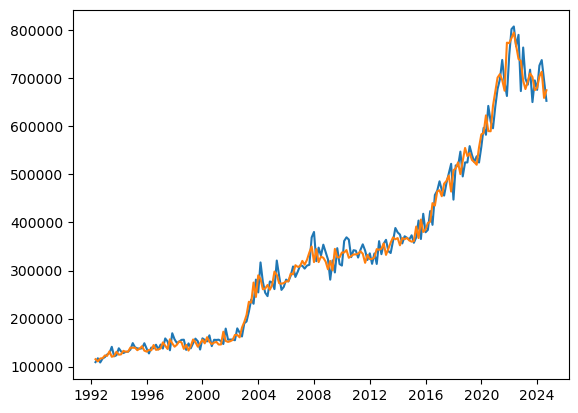

In [238]:
plt.plot(predictions.index, predictions.predictions)
plt.plot(predictions.index, actual.values)

---

### Conclusion

The two month data shows far better ability to predict the mean at an appropriate value. Furthermore, the prediction seems realistic and appears to predict a probably trend. The downside to this model is it can only extrapolate out two months, meaning the forecast horizon will only ever be two months into the future.

It's unfortunate this model couldn't be used in deployment, or in our app for example, as it's possible train this algorithm further, or performing hyperparameter tuning could lead to a very good model.